## Load the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from nltk import word_tokenize
from functools import lru_cache
import re
import unicodedata
import sys
from collections import Counter
import nltk
nltk.download('brown')
from nltk.corpus import brown
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## First part: The Complex Word Identification Model:

In [2]:
Dataset = namedtuple('Dataset', 'name, train, test')
Model = namedtuple('Model', 'type, name, dimension, corpus, model')

###Get the dataset to train the CWI model


In [3]:
!wget https://www.inf.uni-hamburg.de/en/inst/ab/lt/resources/data/complex-word-identification-dataset/cwishareddataset.zip

--2025-01-06 17:25:22--  https://www.inf.uni-hamburg.de/en/inst/ab/lt/resources/data/complex-word-identification-dataset/cwishareddataset.zip
Resolving www.inf.uni-hamburg.de (www.inf.uni-hamburg.de)... 134.100.36.5
Connecting to www.inf.uni-hamburg.de (www.inf.uni-hamburg.de)|134.100.36.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘cwishareddataset.zip’

cwishareddataset.zi     [           <=>      ]   1.03M   502KB/s    in 2.1s    

2025-01-06 17:25:25 (502 KB/s) - ‘cwishareddataset.zip’ saved [1075894]



In [4]:
!unzip cwishareddataset.zip

Archive:  cwishareddataset.zip
   creating: traindevset/
   creating: traindevset/german/
  inflating: traindevset/german/German_Train.tsv  
  inflating: traindevset/german/German_Dev.tsv  
  inflating: traindevset/README.md   
   creating: traindevset/english/
  inflating: traindevset/english/WikiNews_Train.tsv  
  inflating: traindevset/english/Wikipedia_Train.tsv  
  inflating: traindevset/english/Wikipedia_Dev.tsv  
  inflating: traindevset/english/News_Dev.tsv  
  inflating: traindevset/english/News_Train.tsv  
  inflating: traindevset/english/WikiNews_Dev.tsv  
   creating: traindevset/spanish/
  inflating: traindevset/spanish/Spanish_Train.tsv  
  inflating: traindevset/spanish/Spanish_Dev.tsv  
  inflating: README.md               
   creating: testset/
   creating: testset/german/
  inflating: testset/german/German_Test.tsv  
  inflating: testset/README.md       
   creating: testset/english/
  inflating: testset/english/Wikipedia_Test.tsv  
   creating: __MACOSX/
   creating:

In [5]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)
MAIN_PATH_DATASET = "traindevset/english/"
genres = ['Wikipedia', 'WikiNews', 'News']
datasets = ['Train', 'Dev']
columns = ['id', 'sentence', "start", "end", "target",
           "nat", "non_nat", "nat_marked", "non_nat_marked", "binary", "prob"]


datasets = [Dataset('Wikipedia', 'Train', 'Dev'),
            Dataset('WikiNews', 'Train', 'Dev'),
            Dataset('News', 'Train', 'Dev')]

feature_categories = []

def load_df(path):
    df = pd.read_csv(path, header=None, sep = "\t")
    df.columns = columns
    return df

datasets = [Dataset(d.name, load_df(MAIN_PATH_DATASET + d.name + '_' + d.train + '.tsv'),
                            load_df(MAIN_PATH_DATASET + d.name + '_' + d.test + '.tsv'))
                            for d in datasets]

###Get the glove embedding

In [6]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2025-01-06 17:25:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-01-06 17:25:26--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-01-06 17:25:27--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [7]:
!unzip glove.6B.zip -d embeddings

Archive:  glove.6B.zip
  inflating: embeddings/glove.6B.50d.txt  
  inflating: embeddings/glove.6B.100d.txt  
  inflating: embeddings/glove.6B.200d.txt  
  inflating: embeddings/glove.6B.300d.txt  


###Load the embedding model

In [8]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

MAIN_PATH = 'embeddings/'


glove_models = []

glove_defs = [ Model('glove', 'glove.6B.300d.txt', 300, 'wikipedia+gigaword5', None)]

for model in glove_defs:
    glove_file = MAIN_PATH + model.name
    tmp_file = get_tmpfile(model.name + '-temp')
    glove2word2vec(glove_file, tmp_file)
    vecs = KeyedVectors.load_word2vec_format(tmp_file)
    glove_models.append(Model(model.type, model.name, model.dimension, model.corpus, vecs))
    print('load model : {}'.format(model.name))

print(glove_models)

<ipython-input-8-0a27a5859e3f>:15: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, tmp_file)


load model : glove.6B.300d.txt
[Model(type='glove', name='glove.6B.300d.txt', dimension=300, corpus='wikipedia+gigaword5', model=<gensim.models.keyedvectors.KeyedVectors object at 0x791497d73eb0>)]


###Process the Dataset in order to formated it:

In [9]:
dataframe = datasets[0].train[0:30]

def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

def extract_ngrams_group(group):
    targets = zip(group['target'].values.tolist(), group['start'].values.tolist(),
                 group['end'].values.tolist(), group['binary'].values.tolist())
    for word, start, end, binary in targets:
        tokens = word.split()
        if len(tokens)>1:
            olap_words = [(w, b) for w, s, e, b in targets if overlaps(start, end, s, e)]


grouped = dataframe.groupby('sentence').apply(lambda group : extract_ngrams_group(group))

<ipython-input-9-09bec9ffb562>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = dataframe.groupby('sentence').apply(lambda group : extract_ngrams_group(group))


In [10]:
wordlist_lowercased = set(i.lower() for i in brown.words())
print (len(wordlist_lowercased))

49815


###Tokennization and transforming the dabase

In [11]:
tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuation(text):
    return text.translate(tbl)

@lru_cache(maxsize=None)
def all_tokens_with_index(context):
    curr_pos = 0
    targets = []
    j = 0
    w = 0
    curr_split = ''
    ctx_split = context.split()
    whitespaces = re.findall('\s+', context)
    num_whitespaces = [len(token) for token in whitespaces]
    num_whitespaces.append(1)
    tokens = word_tokenize(context)
    tokens = ['"' if token not in context else token for token in tokens]
    for index, token in enumerate(tokens, 1):
        targets.append((token, index, curr_pos, (curr_pos + len(token))))
        curr_pos += len(token)
        curr_split += token
        if ctx_split[j] == curr_split:
            curr_pos += num_whitespaces[w]
            j += 1
            w += 1
            curr_split = ''
    return [val for val in targets if val[0] != '"']

def build_vocabulary(sentences, embedding_model, dimension):
    all_words = [tpl[0] for sentence in sentences for tpl in sentence['seq']] + list(wordlist_lowercased)
    print('# Words : {}'.format(len(all_words)))
    counter = Counter(all_words)
    vocab_size = len(counter) + 1
    print('# Vocab : {}'.format(vocab_size))
    print('# embeding model  : {}'.format(len(embedding_model.key_to_index)))
    word2index = {word : index for index, (word, count) in enumerate(counter.most_common(), 1)}
    index2word = {index : word for word, index in word2index.items()}
    # +1 required for pad token
    embedding_matrix = np.zeros(((vocab_size), dimension))
    missing_embed_words = []
    i_ = 0
    for word, index in word2index.items():
        if word in embedding_model.key_to_index:
            embedding = embedding_model[word]
        else:
             i_ +=1
             continue
        embedding_matrix[index] = embedding
    missing_embed_count = len(missing_embed_words)
    print('# Words missing embedding : {}'.format(missing_embed_count))
    print('Embedding shape : {}'.format(embedding_matrix.shape))
    print("i: ", i_ )
    return word2index, index2word, embedding_matrix

def forward_transformation(dataframe, lowercase = True, filter_punc = True, filtering = "a132"):
    grouped = dataframe.groupby('sentence').apply(lambda row :
                        {'sent_id' : list(set(row['sent_id']))[0],
                         'sentence' : list(set(row['sentence']))[0],
                         'tags': [tag for tag in zip(row['target'],
                            row['start'], row['end'], row['binary'], row['prob'])]})
    sentences = []
    for vals in grouped:
        sent_id = vals['sent_id']
        sentence = vals['sentence']
        tags = vals['tags']
        tags_without_labels = [(word, start, end) for word, start, end, binary, prob in tags]
        all_tokens = all_tokens_with_index(sentence)
        sent_repr = [(word, start, end, tags[tags_without_labels.index((word, start, end))][3],
                     tags[tags_without_labels.index((word, start, end))][4])
           if (word, start, end) in tags_without_labels
          else (word, start, end, 0, 0.0) for word, index, start, end in all_tokens]
        if lowercase:
            sent_repr = [(word.lower(), start, end, binary, prob)
                         for word, start, end, binary, prob in sent_repr]
        if filter_punc:
            sent_repr = list(filter(lambda vals : remove_punctuation(vals[0]), sent_repr))
        if filtering:
            sent_repr = list(filter(lambda vals : vals[0] != "'s", sent_repr))
            sent_repr = list(filter(lambda vals : vals[0] != "``", sent_repr))
        sentences.append({'sent_id' : sent_id, 'sentence' : sentence, 'seq' : sent_repr})
    return sentences

def split_sentence_seqs(sentences):
    words, start_end, binary, prob = [], [], [] ,[]
    for sent in sentences:
        sequence = sent['seq']
        curr_w, curr_se, curr_b, curr_p = map(list, zip(*[(vals[0],
            (vals[1], vals[2]), vals[3], vals[4]) for vals in sequence]))
        words.append(curr_w)
        start_end.append(curr_se)
        binary.append(curr_b)
        prob.append(curr_p)
    return words, start_end, binary, prob

In [12]:
import pandas as pd

datasets.append(Dataset('train_all_test_wiki',
                        pd.concat([datasets[0].train, datasets[1].train, datasets[2].train], ignore_index=True),
                        datasets[0].test))

In [13]:
# Append train and test set
dataset_sel = datasets[3]
train_num_rows = dataset_sel.train.shape[0]
train_num_sents = len(list(set(dataset_sel.train.sentence.values.tolist())))

test_num_rows = dataset_sel.test.shape[0]
test_num_sents = len(list(set(dataset_sel.test.sentence.values.tolist())))

dataset = pd.concat([dataset_sel.train, dataset_sel.test], ignore_index=True)
# The append method has been removed, use pd.concat instead.
# ignore_index=True is added to ensure a continuous index in the combined DataFrame.

dataset['sent_id'] = dataset.groupby('sentence').ngroup()
dataset_num_rows = dataset.shape[0]
dataset_num_sents = len(list(set(dataset.sentence.values.tolist())))

print('# Rows train : {}'.format(train_num_rows))
print('# Rows test : {}'.format(test_num_rows))
print('# Rows dataset : {}'.format(dataset_num_rows))

print('# Sents train : {}'.format(train_num_sents))
print('# Sents test : {}'.format(test_num_sents))
print('# Sents dataset : {}'.format(dataset_num_sents))

# Rows train : 27299
# Rows test : 694
# Rows dataset : 27993
# Sents train : 1988
# Sents test : 53
# Sents dataset : 2041


###Finally the Dataset to train the model:

In [14]:
dataset

,id,sentence,start,end,target,nat,non_nat,nat_marked,non_nat_marked,binary,prob,sent_id
0,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to future generations in a way that recognizes the community 's traditional connection to that country .",0,8,Normally,10,10,0,1,1,0.05,1347
1,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to future generations in a way that recognizes the community 's traditional connection to that country .",28,34,passed,10,10,0,1,1,0.05,1347
2,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to future generations in a way that recognizes the community 's traditional connection to that country .",15,19,land,10,10,0,0,0,0.00,1347
3,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to future generations in a way that recognizes the community 's traditional connection to that country .",43,49,future,10,10,1,0,1,0.05,1347
4,3XU9MCX6VODXPI3L8I02CM94TFB2R7,"Normally , the land will be passed down to future generations in a way that recognizes the community 's traditional connection to that country .",43,61,future generations,10,10,1,2,1,0.15,1347
...,...,...,...,...,...,...,...,...,...,...,...,...
27988,3W0KKJIARRAMOTSFYF06L10TKN9K8Z,Devotion ( Bhakti ) will cancel the effects of bad Karma and will bring a person closer to the true knowledge by purifying his mind .,100,109,knowledge,10,10,0,2,1,0.10,929
27989,3W0KKJIARRAMOTSFYF06L10TKN9K8Z,Devotion ( Bhakti ) will cancel the effects of bad Karma and will bring a person closer to the true knowledge by purifying his mind .,74,80,person,10,10,0,0,0,0.00,929
27990,3W0KKJIARRAMOTSFYF06L10TKN9K8Z,Devotion ( Bhakti ) will cancel the effects of bad Karma and will bring a person closer to the true knowledge by purifying his mind .,95,99,true,10,10,0,0,0,0.00,929
27991,3W0KKJIARRAMOTSFYF06L10TKN9K8Z,Devotion ( Bhakti ) will cancel the effects of bad Karma and will bring a person closer to the true knowledge by purifying his mind .,113,122,purifying,10,10,7,8,1,0.75,929


In [15]:
import nltk

# Download the 'punkt_tab' data package
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [16]:
sentences = forward_transformation(dataset)
train_sentences = sentences[:train_num_sents]
test_sentences = sentences[train_num_sents:]

<ipython-input-11-10a3d27e3f81>:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = dataframe.groupby('sentence').apply(lambda row :


In [17]:
words, start_end, binary, prob = split_sentence_seqs(sentences)

In [18]:
sentence_lens = [len(sent) for sent in words]

###The dimensions of the embedding and vectors for the model:

In [19]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

MAIN_PATH = 'embeddings/'

glove_models = []

glove_defs = [Model('glove', 'glove.6B.300d.txt', 300, 'wikipedia+gigaword5', None)]

for model in glove_defs:
    glove_file = MAIN_PATH + model.name
    tmp_file = get_tmpfile(model.name + '-temp')
    glove2word2vec(glove_file, tmp_file) # Convert GloVe to Word2Vec Format
    vecs = KeyedVectors.load_word2vec_format(tmp_file) #Load the converted model
    # Append the loaded model to the list!
    glove_models.append(Model(model.type, model.name, model.dimension, model.corpus, vecs))
    print('load model : {}'.format(model.name))

print(glove_models)

<ipython-input-19-0c06f7351db3>:14: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, tmp_file) # Convert GloVe to Word2Vec Format


load model : glove.6B.300d.txt
[Model(type='glove', name='glove.6B.300d.txt', dimension=300, corpus='wikipedia+gigaword5', model=<gensim.models.keyedvectors.KeyedVectors object at 0x791497e9ee00>)]


In [20]:
embedding_model = glove_models[0].model
dimension = embedding_model.vector_size
word2index, index2word, embedding = build_vocabulary(sentences, embedding_model, dimension)

# Words : 96437
# Vocab : 52455
# embeding model  : 400000
# Words missing embedding : 0
Embedding shape : (52455, 300)
i:  9834


## Padding the input sequences and get the binaries labels

In [21]:
words_with_indices = [[word2index[word] for word in sent] for sent in words]
sent_lens = [len(sentence['seq']) for sentence in sentences]
sent_max_length = np.max(sent_lens)
print('Max length sentence : {}'.format(sent_max_length))

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

words_padded = pad_sequences(maxlen=sent_max_length, sequences=words_with_indices, padding="post", value=0)
binary_padded = pad_sequences(maxlen=sent_max_length, sequences=binary, padding="post", value=0)
prob_padded = pad_sequences(maxlen=sent_max_length, sequences=prob, padding="post", value=0, dtype="float")

binary_padded_categorical = [to_categorical(clazz, num_classes=2) for clazz in binary_padded]

Max length sentence : 103


# Split the to train and test set


In [22]:
# (1) Training set
train_words_padded = words_padded[:train_num_sents]
train_binary_padded = binary_padded[:train_num_sents]
train_binary_padded_categorical = binary_padded_categorical[:train_num_sents]
train_prob_padded = prob_padded[:train_num_sents]
train_start_end = start_end[:train_num_sents]

# (2) Test set
test_words_padded = words_padded[train_num_sents:]
test_binary_padded = binary_padded[train_num_sents:]
test_binary_padded_categorical = binary_padded_categorical[train_num_sents:]
test_prob_padded = prob_padded[train_num_sents:]
test_start_end = start_end[train_num_sents:]

print('Training set length : {}'.format(len(train_words_padded)))
print('Test set length : {}'.format(len(test_words_padded)))

Training set length : 1988
Test set length : 53


## Create a kera's callback to validate the model on train

In [23]:
from sklearn.metrics import f1_score
import keras.callbacks
from keras import backend as K
class Metrics(keras.callbacks.Callback):
    def __init__(self, validation_data):
        self.f1_scores = []
        self.validation_data = validation_data

    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0]))
        targ = self.validation_data[1]
        targ = np.array(targ)
        shape = targ.shape
        targ = targ.reshape((shape[0]*shape[1], shape[2]))
        targ = np.argmax(targ, axis = 1)
        predict = predict.reshape((shape[0]*shape[1]), shape[2])
        predict = np.argmax(predict, axis = 1)
        self.f1s=f1_score(targ, predict)
        print("\nF1 Score:")
        print(f1_score(targ, np.ones(shape[0]*shape[1])))
        self.f1_scores.append(self.f1s)
        return

## Create the keras model for the Complex Word Identification task

In [24]:
from keras.models import Model
from tensorflow.keras.layers import Input
from keras import backend as K
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

vocab_size = embedding.shape[0]
dimension = embedding.shape[1]

np.set_printoptions(threshold=np.inf)

in_seq = Input(shape=(sent_max_length,))
embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
drop = Dropout(0.1)(embed)
lstm = Bidirectional(LSTM(units=150, return_sequences=True, recurrent_dropout=0.1))(drop)
out = TimeDistributed(Dense(2, activation="softmax"))(lstm)

model = Model(in_seq, out)

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

metrics = Metrics((test_words_padded, np.array(test_binary_padded_categorical)))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 103)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 103, 300)            │      15,736,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 103, 300)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 103, 300)            │         541,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 103, 2)              │             602 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,278,302 (62.10 MB)

 Trainable params: 16,278,302 (62.10 MB)

 Non-trainable params: 0 (0.00 B)

###And Train it:

In [25]:
history = model.fit(train_words_padded, np.array(train_binary_padded_categorical), batch_size=10,
                    epochs=3, validation_data = (test_words_padded, np.array(test_binary_padded_categorical)),
                    verbose=1, callbacks=[metrics])

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step

F1 Score:
0.05660377358490566
199/199 ━━━━━━━━━━━━━━━━━━━━ 162s 763ms/step - accuracy: 0.9540 - loss: 0.1131 - val_accuracy: 0.9793 - val_loss: 0.0430
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

F1 Score:
0.05660377358490566
199/199 ━━━━━━━━━━━━━━━━━━━━ 202s 768ms/step - accuracy: 0.9824 - loss: 0.0408 - val_accuracy: 0.9819 - val_loss: 0.0427
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

F1 Score:
0.05660377358490566
199/199 ━━━━━━━━━━━━━━━━━━━━ 202s 769ms/step - accuracy: 0.9874 - loss: 0.0299 - val_accuracy: 0.9815 - val_loss: 0.0431


###Now let´s plot some chart to see the model performance:

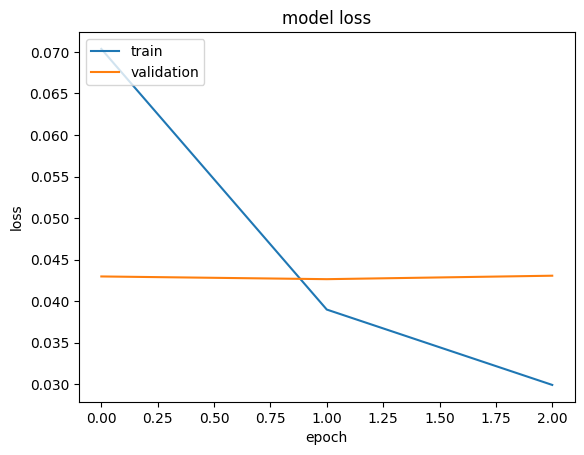

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

###The F1 Score

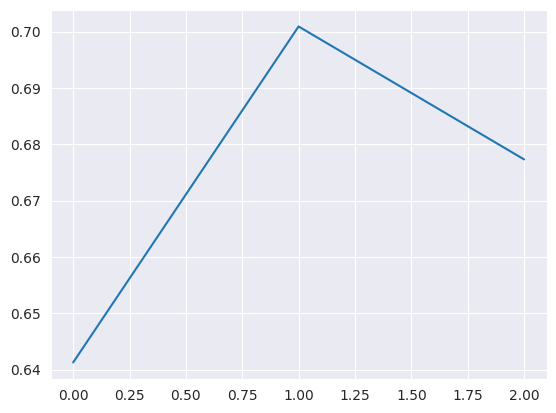

In [27]:
import seaborn as sns
sns.set_style("darkgrid")
epoch_f1s = plt.plot(metrics.f1_scores)
plt.show()

## Optional, if you want to save the trained CWI model into your gdrive

In [28]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [29]:
model_save_name = 'model_CWI_full.h5'
path_dir = F"/content/gdrive/My Drive/{model_save_name}"

###Save the model to google drive

In [30]:
from keras.models import load_model

model.save(path_dir)  # creates a HDF5 file 'model_CWI_full.h5'

###Retrieve the model from google drive (if decide to save it)

In [31]:
from keras.models import load_model

model_cwi = load_model(path_dir)

## Now, let´s define some useful functions in order to use the CWI with some out of samples sentences

###Function for clean the data and remove non characters symbols

In [32]:
stop_words_ = set(stopwords.words('english'))
def cleaner(word):
  #Remove links
  word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*',
                '', word, flags=re.MULTILINE)
  word = re.sub('[\W]', ' ', word)
  word = re.sub('[^a-zA-Z]', ' ', word)
  return word.lower().strip()

###Function for to create the padded sequence

In [33]:

def process_input(input_text):
  input_text = cleaner(input_text)
  clean_text = []
  index_list =[]
  input_token = []
  index_list_zipf = []
  for i, word in enumerate(input_text.split()):
    if word in word2index:
      clean_text.append(word)
      input_token.append(word2index[word])
    else:
      index_list.append(i)
  input_padded = pad_sequences(maxlen=sent_max_length, sequences=[input_token], padding="post", value=0)
  return input_padded, index_list, len(clean_text)


In [34]:
def complete_missing_word(pred_binary, index_list, len_list):
  list_cwi_predictions = list(pred_binary[0][:len_list])
  for i in index_list:
    list_cwi_predictions.insert(i, 0)
  return list_cwi_predictions


# Second part: The Candidates generation and selection using BERT

###First, install the libraries

In [35]:
!pip install transformers
!pip install torch

###Load the BERT  model for masked languge

In [36]:
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM

bert_model = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model)
model = BertForMaskedLM.from_pretrained(bert_model)
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', '

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-

###To compute the **Zipf values**, we use the library **wordfreq**

In [37]:
!pip install wordfreq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00


if we want the Zipf of the word "stop":

In [38]:
from wordfreq import zipf_frequency
zipf_frequency('stop', 'en')


5.52

and for the word "thwart":

In [39]:
from wordfreq import zipf_frequency
zipf_frequency('thwart', 'en')

3.06

As you can see the word "stop" is the most common.

## Now the function to get the candidates out of BERT (MLM):

In [40]:


def get_bert_candidates(input_text, list_cwi_predictions, numb_predictions_displayed = 10):
  list_candidates_bert = []
  for word,pred  in zip(input_text.split(), list_cwi_predictions):
    # if zipf value of word is <3.1 then it is considered complex
    if (pred and (pos_tag([word])[0][1] in ['NNS', 'NN', 'VBP', 'RB', 'VBG','VBD' ]))  or (zipf_frequency(word, 'en')) <3.1:
      replace_word_mask = input_text.replace(word, '[MASK]')
      text = f'[CLS]{replace_word_mask} [SEP] {input_text} [SEP] '
      tokenized_text = tokenizer.tokenize(text)
      masked_index = [i for i, x in enumerate(tokenized_text) if x == '[MASK]'][0]
      indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
      segments_ids = [0]*len(tokenized_text)
      tokens_tensor = torch.tensor([indexed_tokens])
      segments_tensors = torch.tensor([segments_ids])
      # Predict all tokens
      with torch.no_grad():
          outputs = model(tokens_tensor, token_type_ids=segments_tensors)
          predictions = outputs[0][0][masked_index]
      predicted_ids = torch.argsort(predictions, descending=True)[:numb_predictions_displayed]
      predicted_tokens = tokenizer.convert_ids_to_tokens(list(predicted_ids))
      list_candidates_bert.append((word, predicted_tokens))
  return list_candidates_bert




# Simplifying new sentences:

Given a list of new sentences with complex words:

In [41]:
# from flask import Flask, request, jsonify
# import re
# # from your_module_containing_functions import process_input, model_cwi, complete_missing_word, get_bert_candidates
# import numpy as np
# from zipf import zipf_frequency  # Assuming you have the zipf library

# app = Flask(__name__)

# @app.route('/process_sentences', methods=['POST'])
# def process_sentences():
#     data = request.get_json()

#     if 'sentences' not in data:
#         return jsonify({'error': 'Invalid input'}), 400

#     sentences = data['sentences']
#     simplified_sentences = []

#     for input_text in sentences:
#         new_text = input_text
#         input_padded, index_list, len_list = process_input(input_text)
#         pred_cwi = model_cwi.predict(input_padded)
#         pred_cwi_binary = np.argmax(pred_cwi, axis=2)
#         complete_cwi_predictions = complete_missing_word(pred_cwi_binary, index_list, len_list)
#         bert_candidates = get_bert_candidates(input_text, complete_cwi_predictions)

#         for word_to_replace, l_candidates in bert_candidates:
#             tuples_word_zipf = []
#             for w in l_candidates:
#                 if w.isalpha():
#                     tuples_word_zipf.append((w, zipf_frequency(w, 'en')))
#             tuples_word_zipf = sorted(tuples_word_zipf, key=lambda x: x[1], reverse=True)
#             new_text = re.sub(word_to_replace, tuples_word_zipf[0][0], new_text)

#         simplified_sentences.append(new_text)

#     return jsonify({'simplified_sentences': simplified_sentences})

# if __name__ == '__main__':
#     app.run(port=5000)  # You can change the port as needed


In [42]:
list_texts = [
 'The Risk That Students Could Arrive at School With the Coronavirus As schools grapple with how to reopen, new estimates show that large parts of the country would probably see infected students if classrooms opened now.',
 'How a photograph of a young man cradling his dying friend sent me on a journey across India.',
 'Pro-democracy parties, which had hoped to ride widespread discontent to big gains, saw the yearlong delay as an attempt to thwart them.',
 'Night after night, calm gave way to chaos. See what happened between the protesters and the federal agents.',
 'Contact Tracing Is Failing in Many States. Here is Why. Inadequate testing and protracted delays in producing results have crippled tracking and hampered efforts to contain major outbreaks.',
 'After an initial decrease in the youth detention population, the rate of release has slowed, and the gap between white youth and Black youth has grown.'
 'A laboratory experiment hints at some of the ways the virus might elude antibody treatments. Combining therapies could help, experts said.',
 'Though I may not be here with you, I urge you to answer the highest calling of your heart and stand up for what you truly believe.',
 'The research does not prove that infected children are contagious, but it should influence the debate about reopening schools, some experts said.',
 'Dropping antibody counts are not a sign that our immune system is failing against the coronavirus, nor an omen that we can not develop a viable vaccine.',
 'The Senate majority leader has said he will not approve a stimulus package without a “liability shield,” but top White House officials say they do not see it as essential.',
 'Campaign efforts to refocus come as the president continues to push divisive messages that have frustrated his own party.'
]

We apply the simplifier to see how it is performing:

In [44]:
import nltk

# Download the necessary data package
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [45]:
for input_text in list_texts:
  new_text = input_text
  input_padded, index_list, len_list = process_input(input_text)
  pred_cwi = model_cwi.predict(input_padded)
  pred_cwi_binary = np.argmax(pred_cwi, axis = 2)
  complete_cwi_predictions = complete_missing_word(pred_cwi_binary, index_list, len_list)
  bert_candidates =   get_bert_candidates(input_text, complete_cwi_predictions)
  # complex words = word_list[0]
  # synonyms = word_list[1:]
  complex_words= []
  synonyms = []

  for word_list in bert_candidates:
    complex_words.append(word_list[0])
    synonyms.append(word_list[1:])

  print(complex_words)
  print(synonyms)

  for word_to_replace, l_candidates in bert_candidates:
    tuples_word_zipf = []
    for w in l_candidates:
      if w.isalpha():
        tuples_word_zipf.append((w, zipf_frequency(w, 'en')))
    tuples_word_zipf = sorted(tuples_word_zipf, key = lambda x: x[1], reverse=True)

    new_text = re.sub(word_to_replace, tuples_word_zipf[0][0], new_text)
  print("Original text: ", input_text )
  print("Simplified text:", new_text, "\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
['grapple', 'reopen,', 'estimates', 'classrooms']
[(['struggle', 'struggled', 'disagree', 'argue', 'cope', 'debate', 'struggles', 'compete', 'deal', '##apple'],), (['open', 'close', '##open', ',', 'shut', 'operate', 'closure', 'closed', 'reopened', 'shutter'],), (['estimates', 'projections', 'figures', 'reports', 'assessments', 'statistics', 'estimated', 'estimate', 'numbers', 'calculations'],), (['schools', 'classrooms', 'they', 'classes', 'school', 'schoolhouse', 'classroom', 'buildings', 'doors', 'students'],)]
Original text:  The Risk That Students Could Arrive at School With the Coronavirus As schools grapple with how to reopen, new estimates show that large parts of the country would probably see infected students if classrooms opened now.
Simplified text: The Risk That Students Could Arrive at School With the Coronavirus As schools deal with how to open new numbers show that large parts of the country would probably see infected students if

In [46]:
!pip install transformers
!pip install nltk
!pip install bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00


Calculating the efficiency of our model

In [47]:
from transformers import BertTokenizer, BertModel,BertForMaskedLM
import torch
import numpy as np
from bert_score import BERTScorer

In [48]:
for input_text in list_texts:
  new_text = input_text
  input_padded, index_list, len_list = process_input(input_text)
  pred_cwi = model_cwi.predict(input_padded)
  pred_cwi_binary = np.argmax(pred_cwi, axis = 2)
  complete_cwi_predictions = complete_missing_word(pred_cwi_binary, index_list, len_list)
  bert_candidates =   get_bert_candidates(input_text, complete_cwi_predictions)
  for word_to_replace, l_candidates in bert_candidates:
    tuples_word_zipf = []
    for w in l_candidates:
      if w.isalpha():
        tuples_word_zipf.append((w, zipf_frequency(w, 'en')))
    tuples_word_zipf = sorted(tuples_word_zipf, key = lambda x: x[1], reverse=True)
    new_text = re.sub(word_to_replace, tuples_word_zipf[0][0], new_text)
  # BERTScore calculation
  scorer = BERTScorer(model_type='bert-base-uncased')
  P, R, F1 = scorer.score([new_text], [input_text])
  print(f"BERTScore Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTScore Precision: 0.9103, Recall: 0.8894, F1: 0.8997
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
BERTScore Precision: 0.9125, Recall: 0.8708, F1: 0.8911
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
BERTScore Precision: 0.8781, Recall: 0.8406, F1: 0.8589
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
BERTScore Precision: 0.8533, Recall: 0.8335, F1: 0.8433
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
BERTScore Precision: 0.9298, Recall: 0.9100, F1: 0.9198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
BERTScore Precision: 0.8520, Recall: 0.8213, F1: 0.8364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
BERTScore Precision: 0.9871, Recall: 0.9871, F1: 0.9871
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
BERTScore Precision: 0.8773, Recall: 0.8161, F1: 0.8456
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
BERTScore Precision: 0.9695, Recall: 0.9716, F1: 0.9706
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
BERTScore Precision: 0.9105, Recall: 0.8600, F1: 0.8845
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
BERTScore Precision: 0.9133, Recall: 0.8231, F1: 0.8659
